In [1]:
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.utils import resample

## Error functions

In [2]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Exercise 1: OLS on the Franke function
- Mathematical interpretation of OLS: OLS is a projection of the original target vector, y, onto your prediction, $\tilde{y}$, by a matrix $\beta$, which is defined by the coulumn vectors of your matrix X.

## Notes on scaling:
- In this Franke function, x and y is already scaled between 0 and 1
- The function does not vary very much (without noise)
- Recomendation from Morten: Do it yourself. Take design matrix and subtract the mean values, before or after train-test-split
- Scale y as well, y -> y - mean(y), $\beta_0$ = mean(y)

## Results 
- As expected, scaling does not make any significant difference on the mse and $r^2$
- MSE error with noise (mean=0, sigma=1) and N=1000 shrinks from 1.025 to 1 for both test and train
- MSE error without noise and N=1000 shrinks from 0.0225 to 0.0025 for both test and train
- Using low N (~10) can give increased test error, but becomes random each time

## Make Franke function and plot

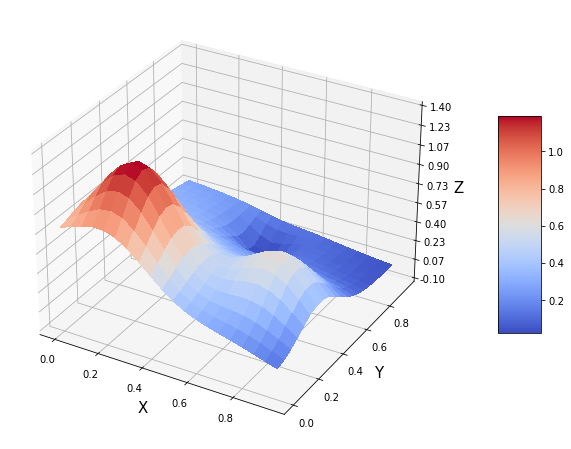

In [50]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0,1,x.shape)
    return term1 + term2 + term3 + term4# + noise


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15)
ax.set_zlabel('Z', fontsize=15)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Make design matrix with polynomial degree n

In [25]:
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of columns in beta
    X = np.ones((N,l)) # matrix with N rows, l columns

    for i in range(1,n+1):
        q = int((i)*(i+1)/2) 
        for k in range(i+1): 
            X[:,q+k] = (x**(i-k))*(y**k)

    return X

## OLS regression with polynomial degree 1-5

In [53]:
# Making meshgrid of datapoints and compute Franke's function
n = 5
N = 1000
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)

polydegree = np.zeros(n)
r2_train = np.zeros(n)
r2_test = np.zeros(n)
mse_train = np.zeros(n)
mse_test = np.zeros(n)

# OLS regression for polynomials from 1 to n
for i in range(n):
    n = i+1
    print(n)
    polydegree[i] = n
    X = create_X(x_flat, y_flat, n)
    #X = X - np.mean(X)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    # prediction
    betaOLS = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    ztilde_train = X_train @ betaOLS
    ztilde_test = X_test @ betaOLS
    
    # errors
    r2_train[i] = r2_score(z_train, ztilde_train)
    r2_test[i] = r2_score(z_test, ztilde_test)
    mse_train[i] = mean_squared_error(z_train, ztilde_train) #MSE(z_train,ztilde_ols_train)
    mse_test[i] = mean_squared_error(z_test, ztilde_test)  #MSE(z_test,ztilde_ols_test)

1
2
3
4
5


## Plot error as function of complexity

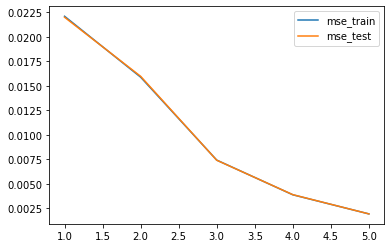

In [54]:
plt.plot(polydegree, mse_train, label='mse_train')
plt.plot(polydegree, mse_test, label='mse_test')
#plt.plot(polydegree, r2_train, label='r2_train')
#plt.plot(polydegree, r2_test, label='r2_test')
plt.legend()
plt.show()

## Make confidence intervals
- $\mu_{\beta} \pm \frac{2\sigma_{\beta}}{\sqrt{n}}$

[  0.29521686   9.09738292   4.28709154 -39.41682736 -16.56538694
 -10.22336599  56.25385298  50.19086412  20.58633888  -5.97039401
 -28.93247949 -60.08766725  -7.47607708 -30.95750307  28.70224276
   2.79676445  20.47940806  13.62954663  -8.445247    18.81504536
 -16.97481331]


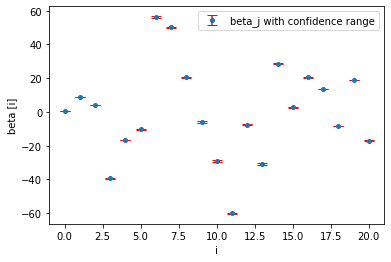

,Beta,+-
0,0.295217,0.004280
1,9.097383,0.044882
2,4.287092,0.045537
3,-39.416827,0.215783
4,-16.565387,0.169244
5,-10.223366,0.210356
6,56.253853,0.487403
7,50.190864,0.354582
8,20.586339,0.362019
9,-5.970394,0.468964


In [7]:
variance = np.zeros(len(betaOLS))
CI = np.zeros(len(betaOLS))

for i in range(len(betaOLS)):
    variance[i] = 0.1**2 * np.linalg.pinv(X_train.T @ X_train)[i,i]
    CI[i] = 2*np.sqrt(variance[i])/np.sqrt(N)
print(betaOLS)

plt.errorbar(np.arange(0,len(betaOLS)), betaOLS, yerr=CI, fmt='o', ecolor='red', capsize=5, markersize=4, label='beta_j with confidence range')
plt.xlabel('i')
plt.ylabel('beta [i]')
plt.legend()
plt.show()

table = pd.DataFrame({'Beta': betaOLS, '+-': CI})
table

# Exercise 2 - Bias-variance trade-off and resampling techniques

## Notes
- scaling or not scaling - no difference as expected (ref notes exercise 1)
- Increasing from 50 bootstraps gives no improved results
- Increasing N from 100 only smoothens the curve
- Polynomial degree above 10 does not decrease errors

## OLS regression with bootstrap 

1
2
3
4
5
6
7
8
9
10


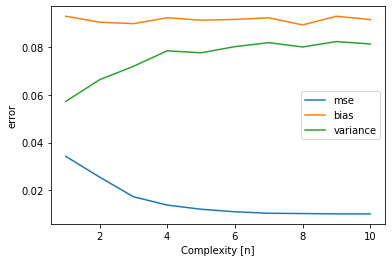

In [8]:
N = 200
n_bootstraps = 30
maxdegree = 10
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

polydegree = np.zeros(maxdegree)
mse_error = np.zeros(maxdegree)
r2_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
mse_est = np.zeros(maxdegree)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)

for i in range(maxdegree):
    degree = i+1
    print(degree)
    polydegree[i] = degree
    X = create_X(x_flat, y_flat, degree)
    #X = X - np.mean(X)
    X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
    
    mse_bs = np.zeros(n_bootstraps)
    bias_bs = np.zeros(n_bootstraps)
    variance_bs = np.zeros(n_bootstraps)
    for j in range(n_bootstraps):
        x_bs,z_bs = resample(X_train, z_train)
        beta = np.linalg.pinv(x_bs.T @ x_bs) @ x_bs.T @ z_bs
        z_pred = X_test @ beta
        
        mse_bs[j] = np.mean((z_test - z_pred)**2)
        bias_bs[j] = np.mean((np.mean(z_pred) - z_test)**2) #np.mean((z_test - np.mean(z_pred))**2)
        variance_bs[j] = np.var(z_pred)
    
    mse_error[i] = np.mean(mse_bs)
    bias[i] = np.mean(bias_bs)
    variance[i] = np.mean(variance_bs)
    
    
plt.plot(polydegree, mse_error, label='mse')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='variance')
plt.xlabel('Complexity [n]')
plt.ylabel('error')
plt.legend()
plt.show()

## Discussion on bias-variance trade-off

- Varier polynomgrad n, punkter N og antall bootstraps n_bootstraps og diskuter forskjellene


# Exercise 3 - cross validation as resampling technique, adding more complexity

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

N = 100
degree = 5
k = 10
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)
mse_scores = []

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)

kfold = KFold(n_splits = k)

for train_indexes, test_indexes in kfold.split(X):
    #print(train_indexes)

    X_train = X[train_indexes]
    X_test = X[test_indexes]
    z_train = z[train_indexes]
    z_test = z[test_indexes]

    beta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ z_train
    print(beta.shape)
    z_pred = X_test @ beta
    mse_scores.append(mean_squared_error(z_test, z_pred))
    #print(mse_scores[i])

print(np.mean(mse_scores))

(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
(21,)
0.021113001689120472


## CV with scikit cross_val_score

In [10]:
linreg = LinearRegression()
mse_scikit_linreg = cross_val_score(linreg, X, z, scoring='neg_mean_squared_error', cv=kfold)


print(np.mean(mse_scikit_linreg))

-0.02111300169348277


# Exercise 4 - Ridge regression on the Franke function with resampling 

- Ridge: Shrinking beta-coefficients with large variance, but never to zero
- Lasso: Same, but can shrink to zero
- Noisy function means large variance
- To compare OLS/ridge/beta, try to compute coefficients and see with/without noise
- Beta coefficients in ridge are given by Gaussian distribution, in Lasso they are given by Laplace distribution (thats why they can go to zero)

- Scaling: Subtracting the mean value means first column of design matrix (1,1,1,...) becomes zero.

In [15]:
N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)

z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)


nlambdas = 100
n_bootstraps = 50
k = 5
kfold = KFold(n_splits = k)
lambdas = np.logspace(-5, 5, nlambdas)
mse_ridge_bs = np.zeros(nlambdas)
mse_ridge_bs_scikit = np.zeros(nlambdas)
mse_ridge_cv = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    # Cross validation
    mse_cv = []
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]

        beta = np.linalg.pinv(X_train.T @ X_train + lmd*np.eye(X_train.shape[1], X_train.shape[1])) @ X_train.T @ z_train
        z_pred = X_test @ beta
        mse_cv.append(mean_squared_error(z_test, z_pred))
    mse_ridge_cv[i] = np.mean(mse_cv)
    
    
    # Bootstrap
    mse_bs = np.zeros(n_bootstraps)
    mse_bs_scikit = np.zeros(n_bootstraps)
    bias_bs = np.zeros(n_bootstraps)
    variance_bs = np.zeros(n_bootstraps)
    
    for j in range(n_bootstraps):
        X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
        x_bs,z_bs = resample(X_train, z_train)
        beta = np.linalg.pinv(x_bs.T @ x_bs + lmd*np.eye(x_bs.shape[1], x_bs.shape[1])) @ x_bs.T @ z_bs
        z_pred = X_test @ beta
        mse_bs[j] = mean_squared_error(z_test, z_pred)
        bias_bs[j] = np.mean((z_test - np.mean(z_pred))**2)
        variance_bs[j] = np.var(z_pred)
    
    mse_ridge_bs[i] = np.mean(mse_bs)
    bias[i] = np.mean(bias_bs)
    variance[i] = np.mean(variance_bs)

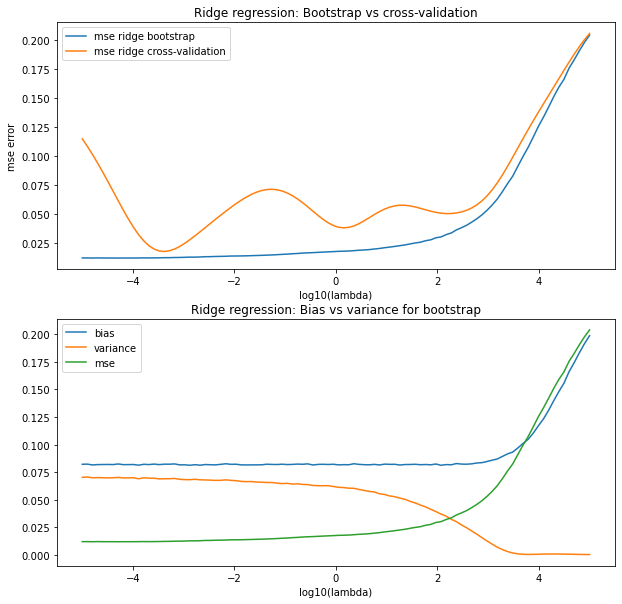

In [17]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_ridge_bs, label='mse ridge bootstrap')
ax[0].plot(np.log10(lambdas), mse_ridge_cv, label='mse ridge cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias, label='bias')
ax[1].plot(np.log10(lambdas), variance, label='variance')
ax[1].plot(np.log10(lambdas), mse_ridge_bs, label='mse')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Ridge regression: Bias vs variance for bootstrap')
plt.show()

1e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.96182445185663, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.56936684681914, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.2477285936306, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.21491087162678, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.50409185608004, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.047615752789664e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.40082907673967, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.94382802272273, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.4147036658473, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.606660694352954, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.91274255170854, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.0974987654930568e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.820853321352665, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.20438066238585, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.53309499692804, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.968565334821655, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.30034349753515, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.1497569953977357e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.706808534801134, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.59977293359756, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.83638676693991, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.29897411728052, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.670172412886494, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.2045035402587812e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.85477138833954, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.908254417400585, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.491717062265295, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.50466444641616, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.01886697327965, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.2618568830660211e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.117845324407725, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.16519721274396, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.730011651350566, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.67812281453851, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.34522645528537, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.3219411484660286e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.407471339940365, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.38017042283194, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.92744146946849, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.83450483496647, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.64698615805377, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.3848863713938746e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.69555952443939, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.554050687803496, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.11720411527796, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.981939290751015, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.92370131224702, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.4508287784959402e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.95303009586041, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.68478043472421, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.30675270155726, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.1006520628417, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.53613147660628, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.5199110829529332e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.053564685493406, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.77048928555796, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.276986060839896, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.18137928511659, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.59477233214616, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.5922827933410938e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.156714245415, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.80853965373812, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.19868144054595, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.2206266877742, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.69269244919019, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.6681005372000593e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.666879505374773, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.800221474562775, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.76834143860828, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.215825574793996, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.777599731967655, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.747528400007683e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.872408787144167, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.74204434138164, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.630607104398557, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.162824276111564, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.86317698942715, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.8307382802953696e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.06487881677095, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.63171598199932, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.474437000064093, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.052297705635176, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.92899811913463, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


1.917910261672489e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.243586456126724, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.47822654568008, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.302764213623078, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.89268261118247, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.97270719287016, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.0092330025650458e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.408403997533803, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.2626805904073, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.538535285192538, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.68013224529781, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.00411177836447, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.104904144512022e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.16128327139235, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.038173891651667, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.63629054221171, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.41411230162469, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.01658114823243, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.2051307399030455e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.258713380972168, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.85055328982071, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.531377506072914, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.096158201921867, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.011802416776128, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.310129700083158e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.34778699692739, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.606800012674192, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.398859133061762, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.725186826410592, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.98370370159155, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.4201282647943835e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.42356402296771, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.320594399584763, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.24195248396346, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.302929643518162, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.929743068259533, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.5353644939701114e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.50095158393146, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.99314122674174, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.073568196125265, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.812728759317174, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.85020337173453, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.656087782946684e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.58903050017271, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.625679120777477, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.873985739418323, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.353487984203596, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.746241010388047, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.782559402207126e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.389659833884807, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.219255013059076, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.972614405316108, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.9183465181519, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.618561000493415, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


2.9150530628251757e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.829933181503954, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.780303700495757, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.09182835462108, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.3745032199987, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.46532362892529, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.053855508833412e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.620170064532395, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.31458096027091, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.22774858951326, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.791593136362472, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.94327963206549, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.199267137797385e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.435175538943106, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.829451797354231, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.099494909198086, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.19288728350236, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.770921878967002, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.351602650938841e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.729021562071573, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.325016538194731, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.862487036787122, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.740906231080245, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.6122411468926, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.511191734215135e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.846161663560338, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.312571973035304, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.079843746251832, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.570565056541966, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.93105965385881, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.678379771828634e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.203729714521792, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.218224230180383, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.47561332858283, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.390600760978387, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.886601648073018, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


3.8535285937105275e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.123045542098993, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.949257535429709, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.63531260265235, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.232695569847905, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.844702481496185, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


4.037017258596558e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.467505133741632, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.015232139036655, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.947677549485583, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.968004836339716, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.804355677939768, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


4.229242874389499e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.560069925509211, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.828496247899636, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.73590288714928, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.73132049690605, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.799202147738285, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


4.430621457583878e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.676117231650991, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.767512318926933, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.528963352945993, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.504418036388984, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.264025311641106, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


4.641588833612782e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.376855909156603, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1342511598965075, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.3348162969763, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.265632604142752, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.80637527253613, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


4.8626015800653536e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7313385966534867, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2140606091766415, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.157271299250084, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.972348643476806, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.367677613044222, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


5.0941380148163855e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.154979588482462, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.303779750685109, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.996038026736542, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.667300729027019, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.996735401044148, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


5.3366992312063123e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.772237494287097, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7784489199170253, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.525928195562742, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.394342107847422, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.504149104118213, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


5.590810182512223e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.986938334360403, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.668032213178236, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.988637030306137, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.174557375523406, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.266662563459519, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


5.8570208180566735e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.332431812914294, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.781006790083538, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.930559620508461, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2717815317446934, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3404977224010395, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


6.135907273413175e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7532635731711252, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.134513438150549, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.934837147694253, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3934589952720273, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.395135199638659, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


6.428073117284319e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2434109680835093, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.780732879759668, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.14633500445197, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5413168691588908, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.41569442925514, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


6.734150657750829e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7857626912865499, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4309290263526293, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.845721347345432, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8218948105525499, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8362104960050374, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


7.054802310718646e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.37438652295684, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1065219325441404, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.970583124705357, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4845025266807568, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8989188169241658, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


7.390722033525775e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0013542233639754, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.804176670231314, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.55006876908557, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.539253786453415, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0440223249670026, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


7.742636826811278e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6558709859393304, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5614259806081492, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.627540642386833, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.057497064356625, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5090956516483516, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


8.111308307896872e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3640108071500663, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5393081304939358, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.757673898751179, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5969948398524565, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4389625154401529, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


8.497534359086438e-05
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14266757615961012, tolerance: 0.13193708267050966
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5780939452025962, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9433890415398594, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.153717055103101, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.396458877511506, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


8.902150854450393e-05
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.24531998568807, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.198850544849691, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.177506676157563, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7303943324018007, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


9.326033468832199e-05
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1603046490491096, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.50579921760864, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1917827805623205, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1069098602717133, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


9.770099572992247e-05
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.764360695627488, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8768853437647692, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.358930907798168, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.530743024652196, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.00010235310218990269
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3388143087921236, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.234690055726304, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6170270276533643, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0005176717239266, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.00010722672220103231
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8948856523372513, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6767092948895481, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.977884621298557, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5150065545410314, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.00011233240329780277
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7345622324895231, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22102701645368938, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6757446367106468, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0749725821914353, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.0001176811952434999
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41630720403190935, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5592565564485596, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6828796683226415, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.0001232846739442066
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2530699834266841, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37983945225667526, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.246341830062022, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34263638431286836, tolerance: 0.2237613658878355
  model = cd_fast.enet_coordinate_descent(


0.0001291549665014884
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1739792955753785, tolerance: 0.14614455423916606
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5692615505228105, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8553457405089375, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
0.00013530477745798074
(2000, 21)
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2999955593211041, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5602959442284714, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
0.00014174741629268049
(2000, 21)
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39672409965751854, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3642297342763925, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
0.0001484968262254465
(2000, 21)
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6013318604229596, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3673399615310302, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
0.00015556761439304722
(2000, 21)
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44450075515564436, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3751992146595171, tolerance: 0.22100747171416626
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
0.00016297508346206434
(2000, 21)
(2000, 21)
(2000, 21)


/Users/Andreas/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21517039524664483, tolerance: 0.20381384583283302
  model = cd_fast.enet_coordinate_descent(


(2000, 21)
(2000, 21)
0.00017073526474706922
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.0001788649529057435
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.0001873817422860385
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00019630406500402724
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00020565123083486514
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00021544346900318845
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00022570197196339215
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00023644894126454073
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.0002477076355991711
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00025950242113997375
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00027185882427329403
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.0002848035868435802
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
(2000, 21)
0.00029836472402833405
(2000, 21)
(2000, 21)
(

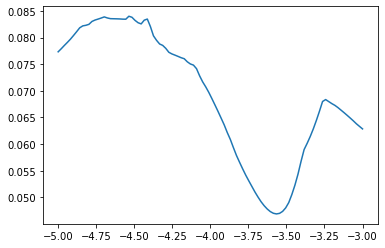

In [13]:
from sklearn.linear_model import Lasso

N = 100
degree = 5
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
x_mesh, y_mesh = np.meshgrid(x,y)
x_flat = np.ravel(x_mesh)
y_flat = np.ravel(y_mesh)


z = FrankeFunction(x_flat, y_flat)
#z = z - np.mean(z)
X = create_X(x_flat, y_flat, degree)
#X = X - np.mean(X)

nlambdas = 100
lambdas = np.logspace(-5, -3, nlambdas)
k = 5
kfold = KFold(n_splits = k)

mse_lasso_bs = np.zeros(nlambdas)
mse_lasso_cv = np.zeros(nlambdas)
bias = np.zeros(nlambdas)
variance = np.zeros(nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    print(lmd)
    # Cross validation
    mse_cv = []
    lassoreg = Lasso(alpha=lmd, fit_intercept=False, max_iter=10000)
    for train_indexes, test_indexes in kfold.split(X):
        X_train = X[train_indexes]
        X_test = X[test_indexes]
        z_train = z[train_indexes]
        z_test = z[test_indexes]
        print(X_test.shape)

        lassoreg.fit(X_train, z_train)
        z_pred = lassoreg.predict(X_test)
        
        mse_cv.append(mean_squared_error(z_test, z_pred))
    mse_lasso_cv[i] = np.mean(mse_cv)

plt.plot(np.log10(lambdas), mse_lasso_cv)
plt.show()

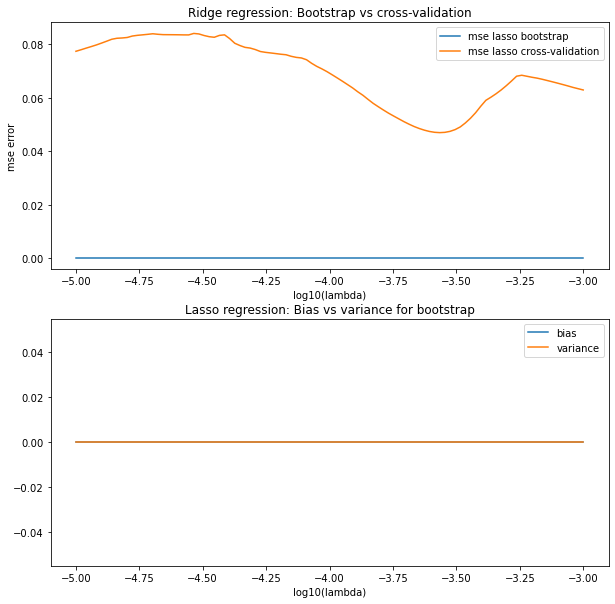

In [14]:
fig,ax = plt.subplots(2, figsize=(10,10))
ax[0].plot(np.log10(lambdas), mse_lasso_bs, label='mse lasso bootstrap')
ax[0].plot(np.log10(lambdas), mse_lasso_cv, label='mse lasso cross-validation')
ax[0].set_xlabel('log10(lambda)')
ax[0].set_ylabel('mse error')
ax[0].legend()
ax[0].set_title('Ridge regression: Bootstrap vs cross-validation')

ax[1].plot(np.log10(lambdas), bias, label='bias')
ax[1].plot(np.log10(lambdas), variance, label='variance')
ax[1].set_xlabel('log10(lambda)')
ax[1].legend()
ax[1].set_title('Lasso regression: Bias vs variance for bootstrap')
plt.show()